In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.layers import conv2d, max_pooling2d, flatten
from tensorflow.nn import relu

import preprocess

In [2]:
# IAM dataset contains 79 chars
charList = preprocess.loadCharList() + '~'
print("Dataset contains %d chars" % len(charList))
maxTextLen = 32

Dataset contains 79 chars


## Example image

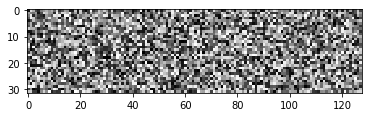

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
img = np.trunc(np.random.random((32, 128)) * 255)
plt.imshow(img, cmap='gray')

# Building model


In [4]:
def buildCNN(inputImgs):
    # in (None, 32, 128, 1)
    # out(None, 1, 32, 256) -> (None, 32, 256)
    with tf.name_scope("CNN"):
        x = tf.expand_dims(input=inputImgs, axis=3)
        
        # Layer 1
        x = conv2d(inputs=x, filters=32, kernel_size=[5, 5], padding='same', activation=relu)
        x = max_pooling2d(x, pool_size=[2, 2], strides=[2, 2], padding="valid")

        # Layer 2
        x = conv2d(inputs=x, filters=64, kernel_size=[5, 5], padding='same', activation=relu)
        x = max_pooling2d(x, pool_size=[2, 2], strides=[2, 2], padding="valid")

        # Layer 3
        x = conv2d(inputs=x, filters=128, kernel_size=[3, 3], padding='same', activation=relu)
        x = max_pooling2d(x, pool_size=[2, 1], strides=[2, 1], padding="valid")

        # Layer 4
        x = conv2d(inputs=x, filters=128, kernel_size=[3, 3], padding='same', activation=relu)
        x = max_pooling2d(x, pool_size=[2, 1], strides=[2, 1], padding="valid")

        # Layer 5
        x = conv2d(inputs=x, filters=256, kernel_size=[3, 3], padding='same', activation=relu)
        x = max_pooling2d(x, pool_size=[2, 1], strides=[2, 1], padding="valid")

    x = tf.squeeze(x, axis=1)
    return x

In [5]:
def buildRNN(inputs):
    with tf.name_scope("RNN"):
        # basic cells which is used to build RNN
        numHidden = 256
        cells = [tf.contrib.rnn.LSTMCell(num_units=numHidden, state_is_tuple=True) for _ in range(2)] # 2 layers

        # stack basic cells
        stacked = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)

        # bidirectional RNN
        # BxTxF -> BxTx2H
        ((fw, bw), _) = tf.nn.bidirectional_dynamic_rnn(cell_fw=stacked, 
                                                        cell_bw=stacked, 
                                                        inputs=inputs, 
                                                        dtype=inputs.dtype)

        # BxTxH + BxTxH -> BxTx2H -> BxTx1X2H
        concat = tf.expand_dims(tf.concat([fw, bw], 2), 2)

        # project output to chars (including blank): BxTx1x2H -> BxTx1xC -> BxTxC
        kernel = tf.Variable(tf.truncated_normal([1, 1, numHidden * 2, len(charList) + 1], stddev=0.1))
        output = tf.squeeze(tf.nn.atrous_conv2d(value=concat, filters=kernel, rate=1, padding='SAME'), axis=2)

    return output

In [6]:
def buildCTC(inputs):
    with tf.name_scope("CTC"):
        x = tf.transpose(inputs, [1, 0, 2])
        # ground truth text as sparse tensor
        gtTextsPlaceholder = tf.SparseTensor(tf.placeholder(tf.int64, shape=[None, 2]), 
                                             tf.placeholder(tf.int32, [None]), 
                                             tf.placeholder(tf.int64, [2]))

        # calc loss for batch
        seqLenPlaceholder = tf.placeholder(tf.int32, [None])
        loss = tf.reduce_mean(tf.nn.ctc_loss(labels=gtTextsPlaceholder, 
                                             inputs=x, 
                                             sequence_length=seqLenPlaceholder, 
                                             ctc_merge_repeated=True))

        # calc loss for each element to compute label probability
        savedCtcInput = tf.placeholder(tf.float32, shape=[maxTextLen, None, len(charList) + 1])
        lossPerElement = tf.nn.ctc_loss(labels=gtTextsPlaceholder, 
                                        inputs=savedCtcInput, 
                                        sequence_length=seqLenPlaceholder, 
                                        ctc_merge_repeated=True)

        # decoder: either best path decoding or beam search decoding
        decoder = tf.nn.ctc_beam_search_decoder(inputs=x, 
                                                sequence_length=seqLenPlaceholder, 
                                                beam_width=50, 
                                                merge_repeated=False)
    
    
    return (gtTextsPlaceholder, seqLenPlaceholder, loss)

# Data flow functions

In [7]:
def toSparse(gtTexts):
    # puts ground truth texts into sparse tensor for ctc_loss
    indices = []
    values = []
    shape = [len(gtTexts), 0] # last entry must be max(labelList[i])

    # go over all texts
    for (batchElement, text) in enumerate(gtTexts):
        # convert to string of label (i.e. class-ids)
        try:
            labelStr = [charList.index(c) for c in text]
        except Exception as e:
            print("cant find char in %s" % text)
            raise e
        # sparse tensor must have size of max. label-string
        if len(labelStr) > shape[1]:
            shape[1] = len(labelStr)
        # put each label into sparse tensor
        for (i, label) in enumerate(labelStr):
            indices.append([batchElement, i])
            values.append(label)

    return (indices, values, shape)


# build net's graph

In [ ]:
with tf.variable_scope("model", reuse=tf.AUTO_REUSE):
    inputImgsPlaceholder = tf.placeholder(tf.float32, shape=(None, 32, 128))
    cnn = buildCNN(inputImgsPlaceholder)
    rnn = buildRNN(cnn)
    gtTextsPlaceholder, seqLenPlaceholder, loss = buildCTC(rnn)
    
    learningRatePlaceholder = tf.placeholder(tf.float32, shape=[])
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.RMSPropOptimizer(learningRatePlaceholder).minimize(loss)


W0817 21:27:01.930171 139999106164544 deprecation.py:323] From <ipython-input-4-8c4604910851>:8: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0817 21:27:01.935371 139999106164544 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0817 21:27:02.231837 139999106164544 deprecation.py:323] From <ipython-input-4-8c4604910851>:9: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0817 21:27:03.139019 139999106164544 lazy_loader.py:50] 
The

# Train network

In [ ]:
batchesTrained = 0

batchesLimit = 10e5
processedBatches = 0

with tf.Session() as sess:
    writer = tf.summary.FileWriter("logs", sess.graph)
    
    for batch in preprocess.batchGenerator(batchSize=4096):
        imgs = batch[0]
        gtTexts = batch[1]
        batchLen = len(imgs)
        sparse = toSparse(gtTexts)
        rate = 0.01 if batchesTrained < 10 else (0.001 if batchesTrained < 10000 else 0.0001) # decay learning rate

        evalList = [optimizer, loss]
        feedDict = {inputImgsPlaceholder : imgs, 
                    gtTextsPlaceholder : sparse , 
                    seqLenPlaceholder : [maxTextLen] * batchLen, 
                    learningRatePlaceholder : rate}
        sess.run(tf.initialize_all_variables())
        (_, lossVal) = sess.run(evalList, feedDict)
        batchesTrained += 1

        print("Batch %d  loss:" % processedBatches, lossVal)

        if processedBatches == batchesLimit:
            break
        else:
            processedBatches += 1

W0817 21:27:06.417391 139999106164544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Batch 0  loss: 119.27845
Batch 1  loss: 124.26478
Batch 2  loss: 121.88769
Batch 3  loss: 112.36948
Batch 4  loss: 122.33439
Batch 5  loss: 121.783195
Batch 6  loss: 119.25175
Batch 7  loss: 120.00135
Corrupted file ./data/words/a01/a01-117/a01-117-05-02.png
Batch 8  loss: 121.71549
Batch 9  loss: 116.92776
Batch 10  loss: 122.30351
Batch 11  loss: 125.79162
Batch 12  loss: 122.46862
Batch 13  loss: 124.24313
Batch 14  loss: 128.01035
Batch 15  loss: 123.210915
Batch 16  loss: 118.34146
Batch 17  loss: 128.12994
Batch 18  loss: 123.05305
Batch 19  loss: 116.86155
Batch 20  loss: 119.795944
Batch 21  loss: 130.1996
Batch 22  loss: 127.40828
Batch 23  loss: 119.045135
Batch 24  loss: 124.261314
Batch 25  loss: 126.803566
Batch 26  loss: 122.09421
Batch 27  loss: 123.871574
Batch 28  loss: 117.63536
Batch 29  loss: 122.10536
Batch 30  loss: 119.97058
Batch 31  loss: 127.85928
Batch 32  loss: 117.72732
Batch 33  loss: 121.64046
Batch 34  loss: 119.643265
Batch 35  loss: 123.152885
Batch 36